## Načítanie knižníc a trénovacieho datasetu

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as ss
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import math

In [2]:
df = pd.read_parquet("ml_dataset_train.parquet")

In [3]:
df.head()

,account_id,n_ad_reward_claims,n_ad_reward_fails,n_ads_watched,n_battlepass_lvls_finished,masked_feature_0,masked_feature_1,masked_feature_2,masked_feature_3,masked_feature_4,...,battlepass_22.0,battlepass_23.0,battlepass_8008.0,first_login_day_time,first_login_country_is_mfreq,time_to_first_purchase,time_to_last_purchase,time_between_last_purchase_last_login,sum_payments_package_key_ltv,n_payments_package_key_ltv
0,100000042,13,<NA>,26,8,175,354.0,354,281.0,141,...,False,False,False,eve,1,NaN,NaN,NaN,NaN,<NA>
1,100000053,<NA>,<NA>,7,1,25,17.0,17,8.0,8,...,False,False,False,morning,1,NaN,NaN,NaN,NaN,<NA>
2,100000082,<NA>,<NA>,<NA>,<NA>,1,NaN,<NA>,NaN,<NA>,...,False,False,False,eve,1,NaN,NaN,NaN,NaN,<NA>
3,100000112,9,<NA>,36,5,72,197.0,197,194.0,83,...,False,False,False,eve,1,NaN,NaN,NaN,NaN,<NA>
4,100000122,<NA>,<NA>,1,3,67,108.0,108,96.0,38,...,False,False,False,eve,1,NaN,NaN,NaN,NaN,<NA>


In [4]:
df.loc[:,["account_id","n_ads_watched","first_login_day_time","sum_payments_package_key","sum_payments_package_key_ltv"]].sort_values(by="sum_payments_package_key_ltv",ascending=False).head()

,account_id,n_ads_watched,first_login_day_time,sum_payments_package_key,sum_payments_package_key_ltv
2494459,169616730,3,early_morning,2854.17,22535.53
2508909,170207391,7,night,968.61,14256.66
2368471,165357101,1,noon,1446.35,11661.82
921994,127826834,<NA>,early_morning,984.62,7641.16
2145973,150404211,105,early_morning,63.89,6348.67


## Úprava datasetu a vyhodenie skrytých údajov(jednalo sa o citlivé údaje klientov)

In [5]:
empty_array = []
for i in range(0,42):
    empty_array.append("masked_feature_" +str(i))
print(empty_array)

['masked_feature_0', 'masked_feature_1', 'masked_feature_2', 'masked_feature_3', 'masked_feature_4', 'masked_feature_5', 'masked_feature_6', 'masked_feature_7', 'masked_feature_8', 'masked_feature_9', 'masked_feature_10', 'masked_feature_11', 'masked_feature_12', 'masked_feature_13', 'masked_feature_14', 'masked_feature_15', 'masked_feature_16', 'masked_feature_17', 'masked_feature_18', 'masked_feature_19', 'masked_feature_20', 'masked_feature_21', 'masked_feature_22', 'masked_feature_23', 'masked_feature_24', 'masked_feature_25', 'masked_feature_26', 'masked_feature_27', 'masked_feature_28', 'masked_feature_29', 'masked_feature_30', 'masked_feature_31', 'masked_feature_32', 'masked_feature_33', 'masked_feature_34', 'masked_feature_35', 'masked_feature_36', 'masked_feature_37', 'masked_feature_38', 'masked_feature_39', 'masked_feature_40', 'masked_feature_41']


In [6]:
df.drop(['masked_feature_0', 'masked_feature_1', 'masked_feature_2', 'masked_feature_3', 'masked_feature_4', 'masked_feature_5', 'masked_feature_6', 'masked_feature_7', 'masked_feature_8', 'masked_feature_9','masked_feature_13','masked_feature_14','masked_feature_15', 'masked_feature_16', 'masked_feature_17', 'masked_feature_18', 'masked_feature_20', 'masked_feature_21', 'masked_feature_22', 'masked_feature_23', 'masked_feature_24', 'masked_feature_25', 'masked_feature_26', 'masked_feature_27', 'masked_feature_28', 'masked_feature_29', 'masked_feature_30', 'masked_feature_31', 'masked_feature_32', 'masked_feature_33', 'masked_feature_34', 'masked_feature_35', 'masked_feature_36', 'masked_feature_37', 'masked_feature_38', 'masked_feature_39', 'masked_feature_40', 'masked_feature_41'],axis=1,inplace=True)

## Rozdelenie a úprava datasetu pre ďalší postup a popisná štatistika jednotlivých častí pre lepší prehľad

In [7]:
# rozdelenie datasetu na buyerov a non_buyerov
buyers = df.loc[(df["sum_payments_package_key_ltv"]>0)]
non_buyers = df.loc[(df["n_payments_package_key_ltv"].isna())]
buyers_count = len(buyers.index)
non_buyers_count = len(non_buyers.index)
buyers_non_buyers_ratio = round((buyers_count/non_buyers_count)*100,2)
print(f"Percento buyerov v datasete {buyers_non_buyers_ratio}")

Percento buyerov v datasete 2.55


In [8]:
#oddelenie numerických premenných pre buyerov od tých ostatných nakoľko v regresných modeloch budeme pracovať len s numerickými premennými
numeric_columns_buyers = buyers.dtypes[buyers.dtypes!=np.object_].index.tolist()
numeric_variables_buyers = buyers.loc[:,numeric_columns_buyers]
# nahradenie nan hodnôt nulov a zbavenie sa boolean hodnot+následne resetnutie indexu aby sme boli schopní pristupovať k dátam 
# cez index
numeric_variables_buyers.fillna(0,inplace = True)
numeric_variables_buyers.drop(["battlepass_0.0","battlepass_22.0","battlepass_23.0","battlepass_8008.0"],inplace=True,axis=1)
numeric_variables_buyers.reset_index(inplace=True,drop=True)

In [9]:
#popisná štatistika čiselných premenných pre buyerov
numeric_variables_buyers.describe()

,n_ad_reward_claims,n_ad_reward_fails,n_ads_watched,n_battlepass_lvls_finished,n_instant_awards_claims,n_extra_challenge_buys,connected_fb,connect_fb_attempt,n_friend_installs,n_accept_all_friends,...,screen_height,nunique_countries,nunique_network_types,nunique_iaps_bought,first_login_country_is_mfreq,time_to_first_purchase,time_to_last_purchase,time_between_last_purchase_last_login,sum_payments_package_key_ltv,n_payments_package_key_ltv
count,69858.000000,69858.000000,69858.000000,69858.000000,69858.000000,69858.000000,69858.000000,69858.000000,69858.000000,69858.000000,...,69858.000000,69858.000000,69858.000000,69858.000000,69858.000000,69858.000000,69858.000000,69858.000000,69858.000000,69858.000000
mean,5.151650,0.489994,35.272553,4.991740,0.115391,0.063543,0.206419,0.282602,0.004867,0.143677,...,936.806350,1.019382,1.778136,2.122506,0.995820,48175.852838,80088.575495,129437.757376,40.296966,4.828595
std,6.234758,1.699919,48.011857,2.924329,0.487982,0.364808,0.487610,0.672475,0.084800,0.697388,...,1064.851624,0.156354,0.600451,2.438195,0.064517,62736.233864,79705.772140,83719.052533,193.073965,10.329313
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.990000,1.000000
25%,0.000000,0.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,3745.560250,7603.239250,55882.351750,2.970000,1.000000
50%,4.000000,0.000000,16.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,2.000000,1.000000,1.000000,15339.556000,52407.527000,136403.448000,4.990000,2.000000
75%,9.000000,0.000000,47.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2009.000000,1.000000,2.000000,2.000000,1.000000,76402.487500,140689.329000,204856.158500,22.980000,4.000000
max,332.000000,95.000000,567.000000,59.000000,9.000000,10.000000,11.000000,21.000000,5.000000,33.000000,...,3200.000000,6.000000,5.000000,63.000000,1.000000,259187.237000,259192.871000,258940.570000,22535.530000,534.000000


In [10]:
#Vyfiltrovanie textových premenných pre buyerov
string_columns_buyers = buyers.dtypes[buyers.dtypes==np.object_].index.tolist()
string_variables_buyers= buyers.loc[:,string_columns_buyers]

In [11]:
#popisná štatistika textových premenných pre buyerov
string_variables_buyers.describe() 

,account_id,device_language,first_device_os,first_time_zone,first_device_model,first_network_type,first_login_country,first_device_manufacturer,is_paid_user,form_factor,most_frequent_country,most_frequent_network_type,first_login_weekday,first_login_day_time
count,69858,69841,69841,69841,69841,69841,69841,69841,69841,31040,69841,69841,69858,69858
unique,69858,43,3,32,2182,4,174,117,2,3,174,5,7,6
top,100000423,en,android,+09:00,"iPhone12,1",WIFI,US,Apple,True,Phone,US,WIFI,Sunday,noon
freq,1,36957,35701,9722,5448,45020,20297,34140,65428,30334,20304,43849,11098,14159


In [12]:
#vyfiltrovanie číselných premenných pre non-buyerov
numeric_columns_non_buyers = non_buyers.dtypes[non_buyers.dtypes!=np.object_].index.tolist()
numeric_variables_non_buyers = non_buyers.loc[:,numeric_columns_non_buyers]

In [13]:
#popisná štatistika číselných premenných pre non-buyerov
numeric_variables_non_buyers.describe()

,n_ad_reward_claims,n_ad_reward_fails,n_ads_watched,n_battlepass_lvls_finished,n_instant_awards_claims,n_extra_challenge_buys,connected_fb,connect_fb_attempt,n_friend_installs,n_accept_all_friends,...,screen_height,nunique_countries,nunique_network_types,nunique_iaps_bought,first_login_country_is_mfreq,time_to_first_purchase,time_to_last_purchase,time_between_last_purchase_last_login,sum_payments_package_key_ltv,n_payments_package_key_ltv
count,225719.000000,182300.000000,924496.000000,758512.000000,6923.000000,10646.000000,106847.000000,144687.000000,1463.000000,26906.000000,...,1.147467e+06,2.742969e+06,2.742969e+06,1282.000000,2.742985e+06,0.0,0.0,0.0,0.0,0
mean,6.681932,1.837926,20.405868,3.516323,1.472916,1.115536,1.106114,1.353515,1.101846,1.580354,...,2.004614e+03,1.010239e+00,1.350424e+00,1.054602,9.972658e-01,NaN,NaN,NaN,NaN,<NA>
std,9.125862,2.492890,34.280043,2.042770,0.864203,0.378111,0.418406,0.890160,0.403325,1.529549,...,3.724043e+02,1.142600e-01,5.387187e-01,0.355812,5.221851e-02,NaN,NaN,NaN,NaN,<NA>
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,5.000000e+00,1.000000e+00,1.000000e+00,1.000000,0.000000e+00,NaN,NaN,NaN,NaN,<NA>
25%,4.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.640000e+03,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,NaN,NaN,NaN,NaN,<NA>
50%,5.000000,1.000000,7.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.009000e+03,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,NaN,NaN,NaN,NaN,<NA>
75%,9.000000,2.000000,22.000000,5.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,...,2.340000e+03,1.000000e+00,2.000000e+00,1.000000,1.000000e+00,NaN,NaN,NaN,NaN,<NA>
max,3038.000000,201.000000,617.000000,59.000000,26.000000,6.000000,22.000000,38.000000,7.000000,71.000000,...,3.840000e+03,9.000000e+00,5.000000e+00,8.000000,1.000000e+00,NaN,NaN,NaN,NaN,<NA>


In [14]:
# Vyfiltrovanie textových premenných pre non-buyerov
string_columns_non_buyers = non_buyers.dtypes[non_buyers.dtypes==np.object_].index.tolist()
string_variables_non_buyers = non_buyers.loc[:,string_columns_non_buyers]

In [15]:
# Popisná štatistika textových premenných pre non-buyerov
string_variables_non_buyers.describe()

,account_id,device_language,first_device_os,first_time_zone,first_device_model,first_network_type,first_login_country,first_device_manufacturer,is_paid_user,form_factor,most_frequent_country,most_frequent_network_type,first_login_weekday,first_login_day_time
count,2742985,2742969,2742985,2742985,2742985,2742985,2742979,2742985,2742637,1147467,2742969,2742969,2742985,2742985
unique,2742985,122,3,39,10438,7,230,1180,2,3,231,6,7,6
top,100000042,en,android,+01:00,"iPhone12,1",WIFI,US,Apple,False,Phone,US,WIFI,Sunday,noon
freq,1,1377856,1440797,376185,233898,1928017,605961,1302189,2738109,1099691,605395,1897433,427703,586142


## Načítanie a úprava testovacieho datasetu

In [16]:
df_test = pd.read_parquet("ml_dataset_test.parquet")
df_test.drop(['masked_feature_0', 'masked_feature_1', 'masked_feature_2', 'masked_feature_3', 'masked_feature_4', 'masked_feature_5', 'masked_feature_6', 'masked_feature_7', 'masked_feature_8', 'masked_feature_9','masked_feature_13','masked_feature_14','masked_feature_15', 'masked_feature_16', 'masked_feature_17', 'masked_feature_18', 'masked_feature_20', 'masked_feature_21', 'masked_feature_22', 'masked_feature_23', 'masked_feature_24', 'masked_feature_25', 'masked_feature_26', 'masked_feature_27', 'masked_feature_28', 'masked_feature_29', 'masked_feature_30', 'masked_feature_31', 'masked_feature_32', 'masked_feature_33', 'masked_feature_34', 'masked_feature_35', 'masked_feature_36', 'masked_feature_37', 'masked_feature_38', 'masked_feature_39', 'masked_feature_40', 'masked_feature_41'],axis=1,inplace=True)
df_test.head()

,account_id,n_ad_reward_claims,n_ad_reward_fails,n_ads_watched,n_battlepass_lvls_finished,n_instant_awards_claims,n_extra_challenge_buys,connected_fb,connect_fb_attempt,n_friend_installs,...,battlepass_22.0,battlepass_23.0,battlepass_8008.0,first_login_day_time,first_login_country_is_mfreq,time_to_first_purchase,time_to_last_purchase,time_between_last_purchase_last_login,sum_payments_package_key_ltv,n_payments_package_key_ltv
12,100000293,<NA>,<NA>,<NA>,2,<NA>,<NA>,2,2,<NA>,...,False,False,False,morning,1,NaN,NaN,NaN,NaN,<NA>
13,100000333,<NA>,<NA>,5,2,<NA>,<NA>,<NA>,<NA>,<NA>,...,False,False,False,morning,1,NaN,NaN,NaN,NaN,<NA>
19,100000463,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,False,False,False,morning,1,NaN,NaN,NaN,NaN,<NA>
24,100000624,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,False,False,False,eve,1,NaN,NaN,NaN,NaN,<NA>
28,100000713,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,False,False,False,morning,1,NaN,NaN,NaN,NaN,<NA>


In [17]:
buyers_test = df_test.loc[(df_test["sum_payments_package_key_ltv"].notna())]
non_buyers_test = df_test.loc[(df_test["n_payments_package_key_ltv"].isna())]
buyers_count_test = len(buyers_test.index)
non_buyers_count_test = len(non_buyers_test.index)
buyers_non_buyers_ratio_test = round((buyers_count_test/non_buyers_count_test)*100,2)
buyers_non_buyers_ratio_test

2.55

In [18]:
#vyfiltrovanie numerickych premennych
buyers_test_numeric_columns = buyers_test.dtypes[buyers_test.dtypes!=np.object_].index.tolist()
buyers_test_numeric_variables = buyers_test.loc[:,buyers_test_numeric_columns]
# odstraneie boolean premenných pre zjednodušenie procesu a nahradenie nan honotami nulov + resetnutie indexu
buyers_test_numeric_variables.drop(["battlepass_0.0","battlepass_22.0","battlepass_23.0","battlepass_8008.0"],axis=1,inplace = True)
buyers_test_numeric_variables.fillna(0,inplace = True)
buyers_test_numeric_variables.reset_index(inplace=True,drop=True)
buyers_test_numeric_variables.head() 

,n_ad_reward_claims,n_ad_reward_fails,n_ads_watched,n_battlepass_lvls_finished,n_instant_awards_claims,n_extra_challenge_buys,connected_fb,connect_fb_attempt,n_friend_installs,n_accept_all_friends,...,screen_height,nunique_countries,nunique_network_types,nunique_iaps_bought,first_login_country_is_mfreq,time_to_first_purchase,time_to_last_purchase,time_between_last_purchase_last_login,sum_payments_package_key_ltv,n_payments_package_key_ltv
0,9,0,14,6,0,0,1,2,0,0,...,0.0,1.0,2.0,4.0,1,31927.439,160283.748,75652.579,22.97,3
1,0,0,2,0,0,0,0,0,0,0,...,2246.0,1.0,1.0,1.0,1,156523.283,156523.283,2633.102,1.99,1
2,10,0,9,6,1,0,0,0,0,0,...,2009.0,1.0,2.0,2.0,1,2835.992,2835.992,156996.617,7.98,2
3,0,0,0,0,0,0,0,0,0,0,...,2340.0,1.0,1.0,1.0,1,5767.520,6143.339,20.807,1.98,2
4,0,0,21,1,0,0,0,0,0,0,...,0.0,1.0,2.0,1.0,1,121212.212,121212.212,112155.156,2.99,1


In [19]:
buyers_test_numeric_variables.describe()

,n_ad_reward_claims,n_ad_reward_fails,n_ads_watched,n_battlepass_lvls_finished,n_instant_awards_claims,n_extra_challenge_buys,connected_fb,connect_fb_attempt,n_friend_installs,n_accept_all_friends,...,screen_height,nunique_countries,nunique_network_types,nunique_iaps_bought,first_login_country_is_mfreq,time_to_first_purchase,time_to_last_purchase,time_between_last_purchase_last_login,sum_payments_package_key_ltv,n_payments_package_key_ltv
count,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,...,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000
mean,5.166599,0.522637,35.175022,5.018142,0.113550,0.058395,0.199158,0.276180,0.005183,0.147323,...,917.080991,1.018628,1.778894,2.130315,0.995869,47926.102443,79903.322838,128830.800572,39.847188,4.815097
std,6.161249,1.743712,47.612478,2.982235,0.504861,0.335889,0.473780,0.674465,0.080330,0.692407,...,1063.721826,0.148897,0.606032,2.439206,0.064139,62810.690690,79620.244017,83704.420949,198.594481,10.309769
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.990000,1.000000
25%,0.000000,0.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,3759.505000,7336.701500,54869.320500,1.995000,1.000000
50%,4.000000,0.000000,17.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,2.000000,1.000000,1.000000,14856.267000,52145.355000,134973.114000,4.990000,2.000000
75%,9.000000,0.000000,47.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2009.000000,1.000000,2.000000,2.000000,1.000000,75674.874500,140535.069500,204529.020000,22.970000,4.000000
max,44.000000,39.000000,635.000000,50.000000,10.000000,8.000000,11.000000,13.000000,3.000000,16.000000,...,3200.000000,4.000000,5.000000,47.000000,1.000000,259119.486000,259197.446000,258530.907000,11701.320000,368.000000


## Lineárna regresia za pomoci scikit learn

In [20]:
X_train = numeric_variables_buyers.iloc[:,:46]
Y_train = numeric_variables_buyers.iloc[:,46].to_frame()

In [21]:
X_test = buyers_test_numeric_variables.iloc[:,:46]
Y_test = buyers_test_numeric_variables.iloc[:,46].to_frame()

In [22]:
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(X_train,Y_train)
y_pred = regr.predict(X_test)

In [23]:
#score parameters
print(f"R^2 skóre pre tréningový dataset: {regr.score(X_train,Y_train)}")
print(f"R^2 skóre pre testovací dataet: {regr.score(X_test,Y_test)}")
print(f"MAE: {mean_absolute_error(Y_test,y_pred)}")
print(f"MSE: {mean_squared_error(Y_test,y_pred)}")

R^2 skóre pre tréningový dataset: 0.42910973974527045
R^2 skóre pre testovací dataet: 0.32150175105689804
MAE: 37.425503741684906
MSE: 26757.646091600756


## Lineárna regresia za pomoci statsmodels

In [24]:
dep_var = Y_train
exp_var = X_train
exp_var = sm.add_constant(exp_var) 

In [25]:
ols = sm.OLS(dep_var.astype(float),exp_var.astype(float))
ols_fit = ols.fit()
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     sum_payments_package_key_ltv   R-squared:                       0.429
Model:                                      OLS   Adj. R-squared:                  0.429
Method:                           Least Squares   F-statistic:                     1166.
Date:                          Tue, 10 May 2022   Prob (F-statistic):               0.00
Time:                                  09:03:36   Log-Likelihood:            -4.4721e+05
No. Observations:                         69858   AIC:                         8.945e+05
Df Residuals:                             69812   BIC:                         8.949e+05
Df Model:                                    45                                         
Covariance Type:                      nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                   -13.0629     12.055     -1.084      0.279     -36.691      10.565
n_ad_reward_claims                        0.1349      0.157      0.861      0.389      -0.172       0.442
n_ad_reward_fails                         0.3777      0.336      1.123      0.261      -0.281       1.037
n_ads_watched                            -0.0063      0.016     -0.404      0.686      -0.037       0.024
n_battlepass_lvls_finished               -2.6146      0.453     -5.772      0.000      -3.503      -1.727
n_instant_awards_claims                  -1.4338      1.308     -1.096      0.273      -3.998       1.130
n_extra_challenge_buys                   10.1637      1.668      6.093      0.000       6.894      13.433
connected_fb                              1.7613      2.049      0.859      0.390      -2.255       5.778
connect_fb_attempt                       -3.7997      1.486     -2.557      0.011      -6.713      -0.887
n_friend_installs                        -7.4802      6.561     -1.140      0.254     -20.340       5.379
n_accept_all_friends                     -0.5976      0.878     -0.681      0.496      -2.318       1.123
n_accept_friend                          -5.4405      1.207     -4.508      0.000      -7.806      -3.075
n_clicked_add_friends                    -1.5095      0.485     -3.115      0.002      -2.459      -0.560
n_friend_searches                        -1.6428      2.271     -0.723      0.470      -6.095       2.809
n_levels_completed                       -0.8634      0.227     -3.811      0.000      -1.307      -0.419
n_calendar_login_days                    -0.0868      0.075     -1.153      0.249      -0.234       0.061
n_missions_completed                      0.0492      0.010      4.769      0.000       0.029       0.069
n_package_info_offers_viewed             -0.0051      0.001     -4.157      0.000      -0.007      -0.003
n_payments_package_key                    0.5058      0.710      0.713      0.476      -0.885       1.896
sum_payments_package_key                  2.6542      0.021    128.932      0.000       2.614       2.695
n_package_tips_offers_viewed             -0.1813      0.035     -5.198      0.000      -0.250      -0.113
rated_game                               -3.0651      1.628     -1.882      0.060      -6.257       0.127
n_remove_ad_clicks                        0.1676      0.831      0.202      0.840      -1.461       1.796
n_sessions_ended                         -0.6952      0.174     -4.005      0.000      -1.035      -0.355
total_session_duration                 6.707e-07   4.42e-08     15.166      0.000    5.84e-07    7.57e-07
max_s

In [26]:
adjusted_X_train = X_train.loc[:,["n_battlepass_lvls_finished","n_extra_challenge_buys","connect_fb_attempt","n_accept_friend","n_clicked_add_friends","n_levels_completed","n_missions_completed","n_package_info_offers_viewed","sum_payments_package_key","n_package_tips_offers_viewed","n_sessions_ended","total_session_duration","n_sessions_started","min_session_start_player_level","n_time_skip_buys","n_viplevels_completed","gdp_per_capita","ram_max","avg_country_spend_30d","avg_country_spend_30d_first3d","nunique_iaps_bought","first_login_country_is_mfreq","time_to_first_purchase","time_between_last_purchase_last_login"]]
adjusted_X_test = X_test.loc[:,["n_battlepass_lvls_finished","n_extra_challenge_buys","connect_fb_attempt","n_accept_friend","n_clicked_add_friends","n_levels_completed","n_missions_completed","n_package_info_offers_viewed","sum_payments_package_key","n_package_tips_offers_viewed","n_sessions_ended","total_session_duration","n_sessions_started","min_session_start_player_level","n_time_skip_buys","n_viplevels_completed","gdp_per_capita","ram_max","avg_country_spend_30d","avg_country_spend_30d_first3d","nunique_iaps_bought","first_login_country_is_mfreq","time_to_first_purchase","time_between_last_purchase_last_login"]]

In [27]:
adj_dep_var = Y_train
adj_exp_var = adjusted_X_train

In [28]:
adj_ols = sm.OLS(adj_dep_var.astype(float),adj_exp_var.astype(float))
adj_ols_fit = adj_ols.fit()
adj_ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     sum_payments_package_key_ltv   R-squared (uncentered):                   0.452
Model:                                      OLS   Adj. R-squared (uncentered):              0.452
Method:                           Least Squares   F-statistic:                              2401.
Date:                          Tue, 10 May 2022   Prob (F-statistic):                        0.00
Time:                                  09:03:38   Log-Likelihood:                     -4.4727e+05
No. Observations:                         69858   AIC:                                  8.946e+05
Df Residuals:                             69834   BIC:                                  8.948e+05
Df Model:                                    24                                                  
Covariance Type:                      nonrobust                                                  
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
n_battlepass_lvls_finished               -0.9648      0.385     -2.504      0.012      -1.720      -0.209
n_extra_challenge_buys                    9.5702      1.658      5.772      0.000       6.320      12.820
connect_fb_attempt                       -3.0423      0.856     -3.553      0.000      -4.721      -1.364
n_accept_friend                          -5.7403      1.192     -4.815      0.000      -8.077      -3.403
n_clicked_add_friends                    -1.8322      0.455     -4.025      0.000      -2.724      -0.940
n_levels_completed                       -0.5088      0.203     -2.501      0.012      -0.908      -0.110
n_missions_completed                      0.0295      0.008      3.880      0.000       0.015       0.044
n_package_info_offers_viewed             -0.0052      0.001     -4.301      0.000      -0.008      -0.003
sum_payments_package_key                  2.6525      0.018    145.390      0.000       2.617       2.688
n_package_tips_offers_viewed             -0.1733      0.035     -5.013      0.000      -0.241      -0.106
n_sessions_ended                         -0.6762      0.171     -3.952      0.000      -1.012      -0.341
total_session_duration                 6.701e-07   4.01e-08     16.718      0.000    5.92e-07    7.49e-07
n_sessions_started                        0.6861      0.170      4.037      0.000       0.353       1.019
min_session_start_player_level            2.8051      0.343      8.185      0.000       2.133       3.477
n_time_skip_buys                          1.5726      0.178      8.832      0.000       1.224       1.922
n_viplevels_completed                    -8.6028      1.036     -8.306      0.000     -10.633      -6.573
gdp_per_capita                            0.0001   3.16e-05      3.940      0.000    6.25e-05       0.000
ram_max                                7.512e-05      0.000      0.385      0.700      -0.000       0.000
avg_country_spend_30d                     0.2512      0.054      4.685      0.000       0.146       0.356
avg_country_spend_30d_first3d            -0.5516      0.122     -4.527      0.000      -0.791      -0.313
nunique_iaps_bought                       3.3901      0.393      8.621      0.000       2.619       4.161
first_login_country_is_mfreq            -12.2027      2.651     -4.603      0.000     -17.399      -7.007
time_to_first_purchase                 1.844e-05   1.07e-05      1.728      0.084   -2.47e-06    3.94e-05
time_between_last_purchase_last_login -2.062e-05   8.48e-06     -2.431      0.015   -3.72e-05      -4e-06
============

## Random forrest regressor 

In [29]:
%%time

from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(n_jobs=-1,n_estimators = 300,max_depth = 50,min_samples_split =5,min_samples_leaf= 2)
rf.fit(X_train, np.ravel(Y_train))
y_pred = rf.predict(X_test)

Wall time: 2min 40s


In [30]:
print(f"R^2 skóre pre trénovací dataset: {rf.score(X_train,Y_train)}")
print(f"R^2 skóre pre testovací dataset: {rf.score(X_test,Y_test)}")
print(f"MAE: {mean_absolute_error(Y_test,y_pred)}")
print(f"MSE: {mean_squared_error(Y_test,y_pred)}")

R^2 skóre pre trénovací dataset: 0.8100572378667296
R^2 skóre pre testovací dataset: 0.29713253695897746
MAE: 34.2381885386101
MSE: 27718.68439549959


In [31]:
def plot_features(columns, importances, n = 20):
    df = (pd.DataFrame(
        {"features": columns, "feature_importances": importances}
    )
    .sort_values("feature_importances", ascending = False)
    .reset_index(drop=True))
    
    fig, ax = plt.subplots(figsize = (15, 10))
    ax.barh(df["features"][:n], df["feature_importances"][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

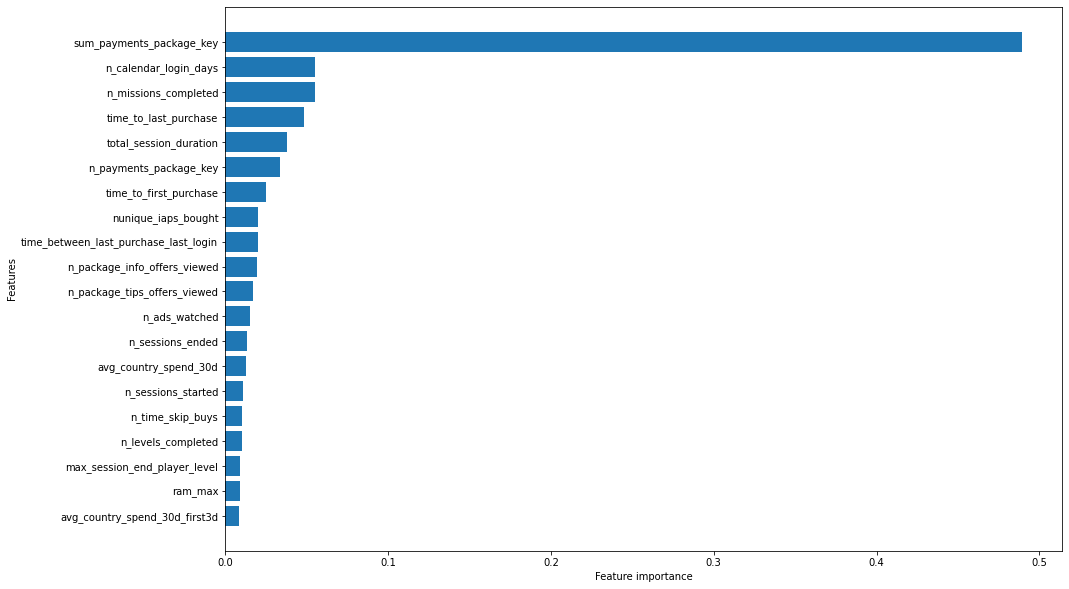

In [32]:
plot_features(X_train.columns, rf.feature_importances_)

## Logaritmická regresia s využitím statsmodels

In [33]:
numeric_variables_buyers_log = []
for i in range(0,len(numeric_variables_buyers)):
    numeric_variables_buyers_log.append(math.log(numeric_variables_buyers.iloc[i,46]))

In [34]:
numeric_variables_buyers_log_test = []
for i in range(0,len(buyers_test_numeric_variables)):
    numeric_variables_buyers_log_test.append(math.log(buyers_test_numeric_variables.iloc[i,46]))

In [35]:
log_y_train = {"sum_payments_package_key_ltv": numeric_variables_buyers_log}
log_y_train = pd.DataFrame(log_y_train)

In [36]:
log_y_test = {"sum_payments_package_key_ltv": numeric_variables_buyers_log_test}
log_y_test = pd.DataFrame(log_y_test)

In [37]:
dep_var = log_y_train
exp_var = X_train
exp_var = sm.add_constant(exp_var) 

In [38]:
ols = sm.OLS(dep_var.astype(float),exp_var.astype(float))
ols_fit = ols.fit()
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     sum_payments_package_key_ltv   R-squared:                       0.486
Model:                                      OLS   Adj. R-squared:                  0.486
Method:                           Least Squares   F-statistic:                     1466.
Date:                          Tue, 10 May 2022   Prob (F-statistic):               0.00
Time:                                  09:06:28   Log-Likelihood:            -1.1022e+05
No. Observations:                         69858   AIC:                         2.205e+05
Df Residuals:                             69812   BIC:                         2.210e+05
Df Model:                                    45                                         
Covariance Type:                      nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.0996      0.097     -1.029      0.304      -0.290       0.090
n_ad_reward_claims                        0.0029      0.001      2.294      0.022       0.000       0.005
n_ad_reward_fails                        -0.0040      0.003     -1.486      0.137      -0.009       0.001
n_ads_watched                            -0.0012      0.000     -9.815      0.000      -0.001      -0.001
n_battlepass_lvls_finished                0.0476      0.004     13.073      0.000       0.040       0.055
n_instant_awards_claims                  -0.0100      0.011     -0.947      0.344      -0.031       0.011
n_extra_challenge_buys                   -0.0805      0.013     -6.006      0.000      -0.107      -0.054
connected_fb                             -0.0206      0.016     -1.250      0.211      -0.053       0.012
connect_fb_attempt                        0.0239      0.012      1.998      0.046       0.000       0.047
n_friend_installs                        -0.0539      0.053     -1.022      0.307      -0.157       0.049
n_accept_all_friends                     -0.0169      0.007     -2.395      0.017      -0.031      -0.003
n_accept_friend                          -0.0552      0.010     -5.696      0.000      -0.074      -0.036
n_clicked_add_friends                    -0.0138      0.004     -3.535      0.000      -0.021      -0.006
n_friend_searches                         0.0196      0.018      1.071      0.284      -0.016       0.055
n_levels_completed                       -0.0002      0.002     -0.116      0.908      -0.004       0.003
n_calendar_login_days                     0.0006      0.001      1.033      0.302      -0.001       0.002
n_missions_completed                      0.0003   8.28e-05      3.425      0.001       0.000       0.000
n_package_info_offers_viewed             -0.0001   9.78e-06    -11.395      0.000      -0.000   -9.22e-05
n_payments_package_key                   -0.0195      0.006     -3.419      0.001      -0.031      -0.008
sum_payments_package_key                  0.0040      0.000     24.182      0.000       0.004       0.004
n_package_tips_offers_viewed              0.0011      0.000      3.904      0.000       0.001       0.002
rated_game                               -0.0076      0.013     -0.584      0.559      -0.033       0.018
n_remove_ad_clicks                        0.0144      0.007      2.160      0.031       0.001       0.028
n_sessions_ended                         -0.0060      0.001     -4.268      0.000      -0.009      -0.003
total_session_duration                 5.519e-09   3.55e-10     15.532      0.000    4.82e-09    6.22e-09
max_s

In [39]:
#OLS regresia po vyhodení nevýznamných premenných
dep_var = log_y_train
exp_var = X_train.drop(["n_ad_reward_fails","n_instant_awards_claims","connected_fb","n_friend_searches","n_levels_completed","n_calendar_login_days","rated_game","max_session_end_player_level","screen_density","avg_country_spend_30d","n_friend_installs"],axis=1)
exp_var = sm.add_constant(exp_var) #bola aj tak nevyznamna a zvysilo to kvalitu modelu plus umoznilo robit predict cez tuto kniznicu

In [40]:
ols = sm.OLS(dep_var.astype(float),exp_var.astype(float))
ols_fit = ols.fit()
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     sum_payments_package_key_ltv   R-squared:                       0.486
Model:                                      OLS   Adj. R-squared:                  0.486
Method:                           Least Squares   F-statistic:                     1940.
Date:                          Tue, 10 May 2022   Prob (F-statistic):               0.00
Time:                                  09:06:28   Log-Likelihood:            -1.1023e+05
No. Observations:                         69858   AIC:                         2.205e+05
Df Residuals:                             69823   BIC:                         2.208e+05
Df Model:                                    34                                         
Covariance Type:                      nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.0834      0.096     -0.865      0.387      -0.272       0.106
n_ad_reward_claims                        0.0032      0.001      2.561      0.010       0.001       0.006
n_ads_watched                            -0.0013      0.000    -10.476      0.000      -0.002      -0.001
n_battlepass_lvls_finished                0.0484      0.004     13.389      0.000       0.041       0.055
n_extra_challenge_buys                   -0.0808      0.013     -6.053      0.000      -0.107      -0.055
connect_fb_attempt                        0.0122      0.007      1.775      0.076      -0.001       0.026
n_accept_all_friends                     -0.0176      0.007     -2.505      0.012      -0.031      -0.004
n_accept_friend                          -0.0557      0.010     -5.772      0.000      -0.075      -0.037
n_clicked_add_friends                    -0.0134      0.004     -3.516      0.000      -0.021      -0.006
n_missions_completed                      0.0004   6.44e-05      5.543      0.000       0.000       0.000
n_package_info_offers_viewed             -0.0001   9.76e-06    -11.432      0.000      -0.000   -9.24e-05
n_payments_package_key                   -0.0198      0.006     -3.473      0.001      -0.031      -0.009
sum_payments_package_key                  0.0040      0.000     24.196      0.000       0.004       0.004
n_package_tips_offers_viewed              0.0012      0.000      4.157      0.000       0.001       0.002
n_remove_ad_clicks                        0.0143      0.007      2.140      0.032       0.001       0.027
n_sessions_ended                         -0.0061      0.001     -4.412      0.000      -0.009      -0.003
total_session_duration                 5.575e-09   3.53e-10     15.798      0.000    4.88e-09    6.27e-09
max_session_end_viplevel              -3.787e-13   1.19e-13     -3.185      0.001   -6.12e-13   -1.46e-13
n_sessions_started                        0.0057      0.001      4.206      0.000       0.003       0.008
min_session_start_viplevel                0.3810      0.120      3.182      0.001       0.146       0.616
min_session_start_player_level            0.0180      0.003      6.568      0.000       0.013       0.023
n_time_skip_buys                         -0.0033      0.001     -2.330      0.020      -0.006      -0.001
n_viplevels_completed                     0.2790      0.008     32.927      0.000       0.262       0.296
bigmac_dollar_price                      -0.0110      0.003     -3.957      0.000      -0.017      -0.006
gdp_per_capita                         1.031e-05   2.53e-07     40.770      0.000    9.82e-06    1.08e-05
ram_m

## Logaritmická regresia s využitím scikit learn

In [41]:
log_regr = linear_model.LinearRegression()
log_regr.fit(X_train,log_y_train)
log_y_pred = log_regr.predict(X_test)

In [42]:
print(f"R^2 skóre pre trénovací dataset: {log_regr.score(X_train,log_y_train)}")
print(f"R^2 skóre pre testovací dataset: {log_regr.score(X_test,log_y_test)}")
print(f"MAE: {mean_absolute_error(log_y_test,log_y_pred)}")
print(f"MSE: {mean_squared_error(log_y_test,log_y_pred)}")

R^2 skóre pre trénovací dataset: 0.4858580870613012
R^2 skóre pre testovací dataset: 0.48657989683267544
MAE: 0.9117724763516878
MSE: 1.364544725679814


In [43]:
#logaritmicka regresia po vyhodení nevýznamných premenných
adj_for_log_X_test = X_test.drop(["n_ad_reward_fails","n_instant_awards_claims","connected_fb","n_friend_searches","n_levels_completed","n_calendar_login_days","rated_game","max_session_end_player_level","screen_density","avg_country_spend_30d","n_friend_installs"],axis=1)
adj_for_log_X_train = X_train.drop(["n_ad_reward_fails","n_instant_awards_claims","connected_fb","n_friend_searches","n_levels_completed","n_calendar_login_days","rated_game","max_session_end_player_level","screen_density","avg_country_spend_30d","n_friend_installs"],axis=1)
log_regr = linear_model.LinearRegression()
log_regr.fit(adj_for_log_X_train,log_y_train)
log_y_pred = log_regr.predict(adj_for_log_X_test)

In [44]:
print(f"R^2 skóre pre trénovací dataset: {log_regr.score(adj_for_log_X_train,log_y_train)}")
print(f"R^2 skóre pre testovací dataset: {log_regr.score(adj_for_log_X_test,log_y_test)}")
print(f"MAE: {mean_absolute_error(log_y_test,log_y_pred)}")
print(f"MSE: {mean_squared_error(log_y_test,log_y_pred)}")

R^2 skóre pre trénovací dataset: 0.4857734905808355
R^2 skóre pre testovací dataset: 0.48647918701665516
MAE: 0.9117657207651216
MSE: 1.3648123876732323
